## SETUP

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## PARAMETERS

In [24]:
image_size = 256
generator_input = int(image_size/8)
batch_size = 8

## IMPORT

In [25]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "images_proc/full_selection_sel", label_mode=None, image_size=(image_size, image_size), batch_size=batch_size, crop_to_aspect_ratio=True
)
dataset = dataset.map(lambda x: x / 255.0)

Found 2544 files belonging to 1 classes.


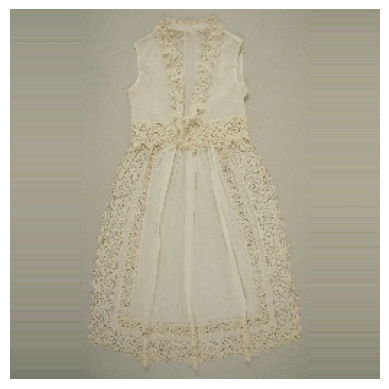

In [26]:
# display one image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## DISCRIMINATOR

In [27]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 131072)          

## GENERATOR

In [28]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(generator_input * generator_input * 128),
        layers.Reshape((generator_input, generator_input, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 131072)            16908288  
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 128, 128, 256)    524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128, 128, 256)     0 

## GAN

In [29]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## GAN monitor

In [30]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("BasicGAN_gen/9/generated_img_%03d_%d.png" % (epoch, i))

## FIT

In [31]:
learning_rate = 0.0001

In [36]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/50
318/318 [==============================] - 84s 261ms/step - d_loss: 0.6151 - g_loss: 1.8480
Epoch 2/50
318/318 [==============================] - 85s 268ms/step - d_loss: 0.6371 - g_loss: 1.3369
Epoch 3/50
318/318 [==============================] - 83s 260ms/step - d_loss: 0.5695 - g_loss: 1.5020
Epoch 4/50
318/318 [==============================] - 84s 262ms/step - d_loss: 0.5752 - g_loss: 1.2601
Epoch 5/50
318/318 [==============================] - 84s 263ms/step - d_loss: 0.5852 - g_loss: 1.4548
Epoch 6/50
318/318 [==============================] - 85s 267ms/step - d_loss: 0.5153 - g_loss: 1.5085
Epoch 7/50
318/318 [==============================] - 87s 273ms/step - d_loss: 0.6064 - g_loss: 1.4588
Epoch 8/50
318/318 [==============================] - 84s 264ms/step - d_loss: 0.5877 - g_loss: 1.3969
Epoch 9/50
318/318 [==============================] - 83s 260ms/step - d_loss: 0.5499 - g_loss: 1.6948
Epoch 10/50
318/318 [==============================] - 83s 261ms/step - d

In [ ]:
# load_status = gan.load_weights('BasicGAN_gen/8/GAN_8.ckpt')
# load_status.assert_consumed()

In [ ]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

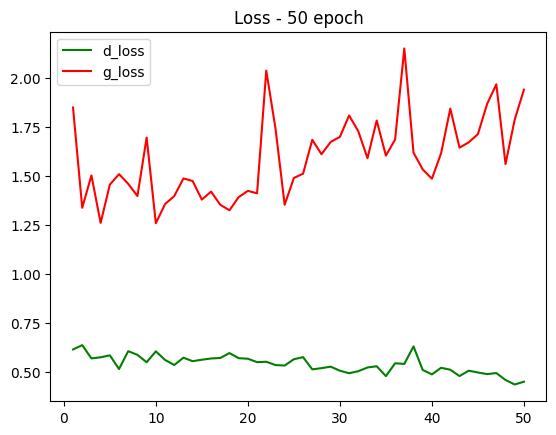

In [48]:
d_loss = gan.history.history['d_loss']
g_loss = gan.history.history['g_loss']
epch = range(1,len(d_loss)+1)
plt.plot(epch, d_loss,'g', label='d_loss')
plt.plot(epch, g_loss,'r', label='g_loss')
plt.title("Loss - 50 epoch")
plt.legend();

In [47]:
gan.save_weights(filepath='BasicGAN_gen/9/GAN_9_50.ckpt')